In [11]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# ====== CẤU HÌNH ======
image_path = "../Image-Caption-Using-CNN-LSTM"
model_path = "model1.keras"
tokenizer_path = "image_features1.pkl"
features_path = "features.pkl"
max_length = 74  # Thay bằng giá trị thực tế từ training
vocab_size = None  # Sẽ được tự tính từ tokenizer
img_size = 224

# ====== 1. LOAD MODEL CHÍNH ======
caption_model = load_model(model_path)

# ====== 2. LOAD TOKENIZER ======
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
vocab_size = len(tokenizer.word_index) + 1

# ====== 3. LOAD FEATURES (TRÍCH ĐẶC TRƯNG ẢNH) NẾU CÓ ======
if os.path.exists(features_path):
    with open(features_path, 'rb') as f:
        features = pickle.load(f)
else:
    features = {}

# ====== 4. MODEL TRÍCH ĐẶC TRƯNG ẢNH (DENSENET201) ======
base_model = DenseNet201(include_top=True, weights='imagenet')
fe_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# ====== 5. HÀM SINH CHÚ THÍCH ======
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '')

# ====== 6. HÀM DỰ ĐOÁN CHO MỘT ẢNH ======
def predict_caption_for_image(image_file):
    if image_file in features:
        photo = features[image_file]
    else:
        img_path = os.path.join(image_path, image_file)
        img = load_img(img_path, target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        photo = fe_model.predict(img, verbose=0)
    caption = generate_caption(caption_model, tokenizer, photo, max_length)
    return caption


# ====== 7. TEST ẢNH MỚI (CÓ BLEU SCORE) ======
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ====== 7. TEST ẢNH MỚI (CÓ BLEU SCORE) ======
def test_image(image_file, reference_captions=None):
    caption = predict_caption_for_image(image_file)
    print("Predicted Caption:", caption)

    # Hiển thị ảnh
    img_path = os.path.join(image_path, image_file)
    img = load_img(img_path)
    plt.imshow(img)
    plt.title("\n".join(caption.split()))
    plt.axis('off')
    plt.show()

    # Nếu có chú thích thực tế → tính BLEU
    if reference_captions:
        smooth = SmoothingFunction().method1
        reference_tokens = [ref.lower().split() for ref in reference_captions]
        candidate = caption.lower().split()

        print("\n--- BLEU SCORES ---")
        print("BLEU-1:", sentence_bleu(reference_tokens, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth))
        print("BLEU-2:", sentence_bleu(reference_tokens, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
        print("BLEU-3:", sentence_bleu(reference_tokens, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth))
        print("BLEU-4:", sentence_bleu(reference_tokens, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))




Predicted Caption: black dog is running in the grass


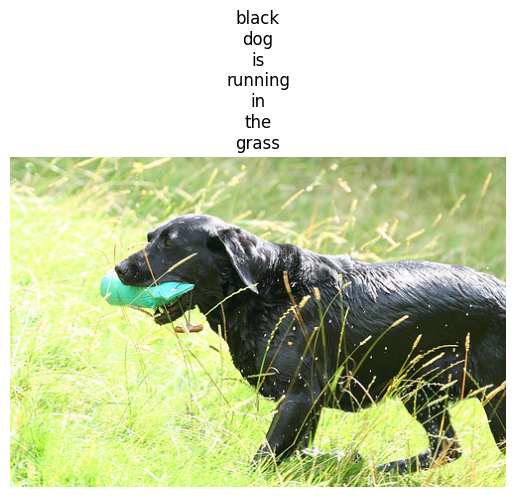


--- BLEU SCORES ---
BLEU-1: 0.8668778997501817
BLEU-2: 0.8668778997501817
BLEU-3: 0.8668778997501817
BLEU-4: 0.8668778997501817


In [12]:
if __name__ == "__main__":
    test_image(
        "img.png",
        reference_captions=[
            "A black dog is running in the grass"
        ]
    )


In [2]:
!pip install nltk



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
